In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

##Import any other packages you may need here

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [2]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(3)

## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
128,00000733_003.png,Fibrosis,3,733,072Y,M,PA,2746,2991,0.143,0.143
28,00000165_008.png,No Finding,8,165,078Y,M,PA,2940,2900,0.143,0.143
882,00004659_000.png,Edema,0,4659,035Y,F,AP,2500,2048,0.171,0.171


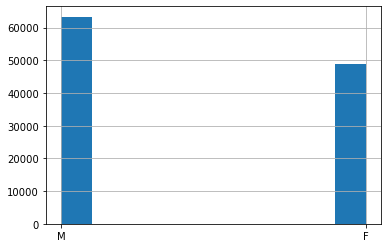

In [4]:
## EDA
# Todo 
all_xray_df["Patient Gender"].hist()


The frequency of males in our dataset tops that of females significantly.  This would be of relative advantage to the male gender features which we shall use in feeding our model


Text(0.5, 0, 'Age')

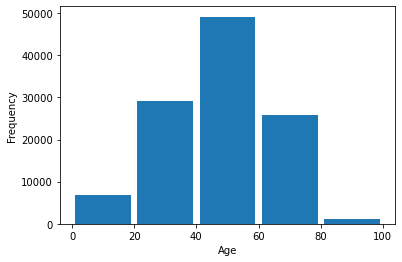

In [17]:
 '''
justAge=sample_df['Patient Age'].astype(str).str[:-1].astype(np.int64)
justAge.plot(kind='hist',bins=[0,20,40,60,80,100],rwidth=0.9)
plt.xlabel('Age')
'''
justAge=all_xray_df['Patient Age'] 
justAge.plot(kind='hist',bins=[0,20,40,60,80,100],rwidth=0.9)
plt.xlabel('Age')

In [18]:
#sample_df['Finding Labels'][:].value_counts().plot.bar()
 
#dfa = sample_df.groupby(['Finding Labels','Patient Age','Patient Gender'])['Finding Labels'].count().reset_index(name='distribution')
dfTable= all_xray_df.groupby(['Finding Labels'])['Finding Labels'].count().reset_index(name='distribution')
dfTable['distribution'] = dfTable['distribution'] / dfTable['distribution'].sum()
print(dfTable)

 

                                        Finding Labels  distribution
0                                          Atelectasis      0.037594
1                             Atelectasis|Cardiomegaly      0.000785
2               Atelectasis|Cardiomegaly|Consolidation      0.000089
3         Atelectasis|Cardiomegaly|Consolidation|Edema      0.000009
4    Atelectasis|Cardiomegaly|Consolidation|Edema|E...      0.000018
..                                                 ...           ...
831                                       Pneumothorax      0.019568
832                           Pneumothorax|Atelectasis      0.000009
833                          Pneumothorax|Infiltration      0.000018
834                                  Pneumothorax|Mass      0.000009
835                             Pneumothorax|Pneumonia      0.000018

[836 rows x 2 columns]


Text(0, 0.5, 'Frequency')

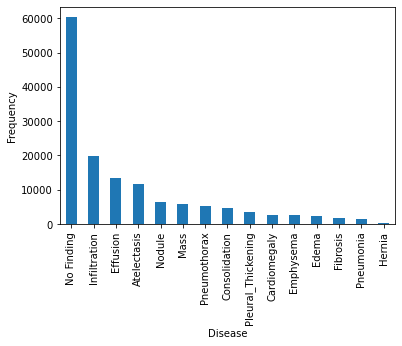

In [23]:
from itertools import chain
df = all_xray_df.copy()
labels = np.unique(list(chain(*df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
for i in labels:
    if i:
        df[i] = df['Finding Labels'].map(lambda x: 1 if i in x else 0)
    
df.iloc[0]

df[labels].sum().sort_values(ascending=False).plot.bar() 
plt.xlabel("Disease")
plt.ylabel("Frequency")
 

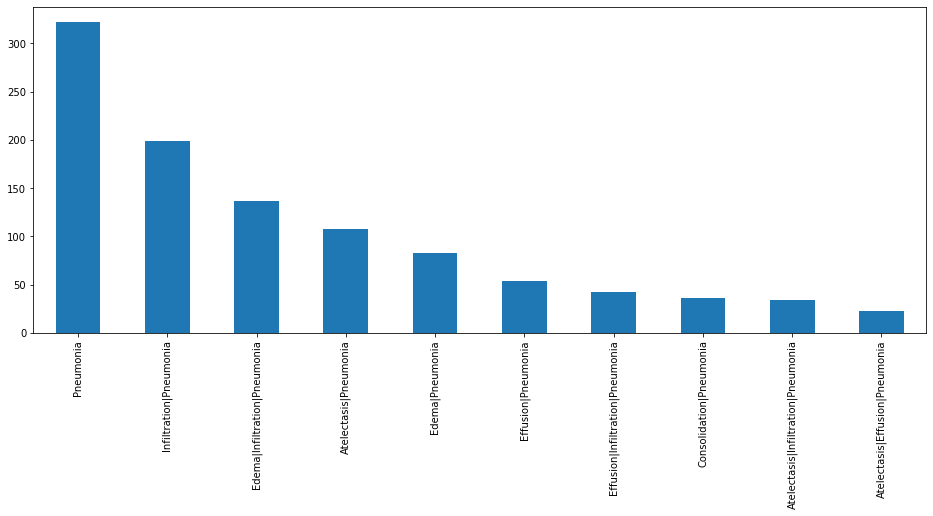

In [24]:
#first ten cases comorbid to Pneumonia
plt.figure(figsize=(16,6))
df[df.Pneumonia==1]['Finding Labels'].value_counts()[0:10].plot.bar() 

In [19]:
#View Position
b=all_xray_df['View Position'].value_counts()
b.sample(frac=3, replace=True)

AP    44810
AP    44810
PA    67310
AP    44810
AP    44810
PA    67310
Name: View Position, dtype: int64

From the above statistics, one can conclude that we have a massive number of view position and image pixel in our dataset, both from females and males Therefore, rescaling the dataset set should impact the kind of data we will fit into our model

In [26]:
col=all_xray_df['Finding Labels']
#all_xray_df[all_xray_df['Finding Labels'].str.contains("Pneumonia")]
filtered_data = col.groupby([col=="Pneumonia"]).count()
print ("Pneumonia ", filtered_data[1],"vs other diseases", filtered_data[0])


Pneumonia  322 vs other diseases 111798


/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:3

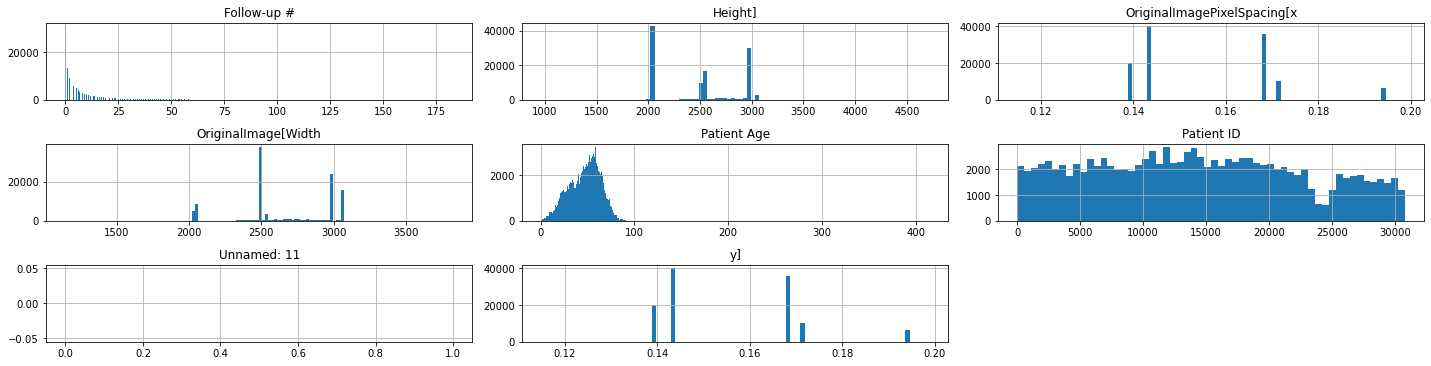

In [25]:
all_xray_df.hist(figsize = (20, 10), layout=(6, 3), bins = 'auto')
plt.tight_layout()
plt.savefig('hip_chart.png')
plt.show()

from the chart, we can see how most of our patient's ID variables are frequent and almost all at a constant level, as opposed to the follow-up variable with almost none frequencies at large and a very high number of occurrence at the initial stage


<b>Let's try to correlate our data</b>

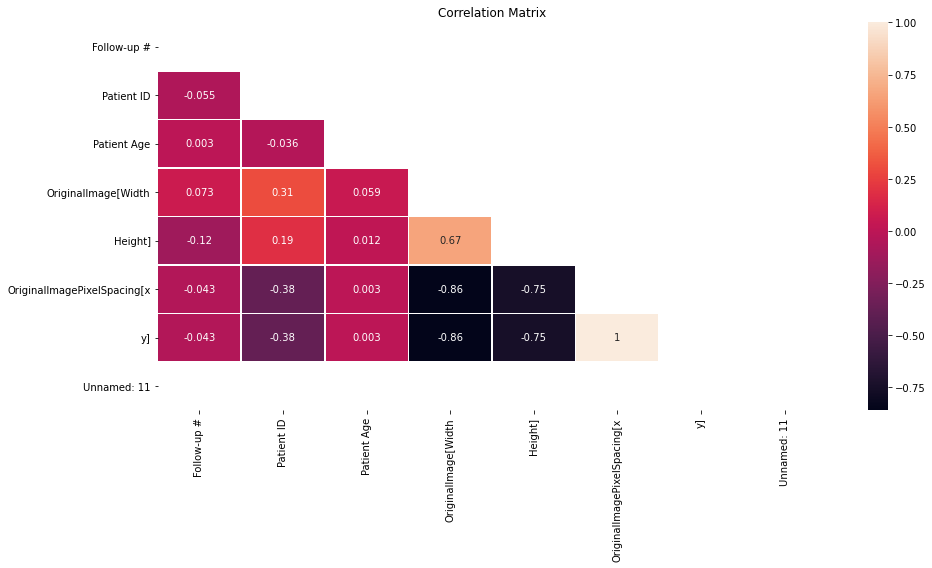

In [28]:
plt.figure(figsize = (14, 8))
mask = np.triu(np.ones_like(all_xray_df.corr(), dtype=bool))
sns.heatmap(round(all_xray_df.corr(method = 'spearman'), 3), mask=mask, annot=True, linewidths=0.5)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.savefig('cormat.png')
plt.show()

The graph is a negative correlation as the Y-axis appears to be decreasing while the X-axis inclines. On a good note, having a predictive modeling algorithm like the linear regression maybe just a good choice for this data. I also think the data is not enough but good thing linear regression can extrapolation beyond a specific data set  as we  essentially crunch the numbers for better predictions



# Pixel Level Assesments

In [55]:
 
print(sample_df.dtypes)
sample_df.info()

Image Index                     object
Finding Labels                  object
Follow-up #                      int64
Patient ID                       int64
Patient Age                     object
Patient Gender                  object
View Position                   object
OriginalImageWidth               int64
OriginalImageHeight              int64
OriginalImagePixelSpacing_x    float64
OriginalImagePixelSpacing_y    float64
dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5606 entries, 0 to 5605
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Image Index                  5606 non-null   object 
 1   Finding Labels               5606 non-null   object 
 2   Follow-up #                  5606 non-null   int64  
 3   Patient ID                   5606 non-null   int64  
 4   Patient Age                  5606 non-null   object 
 5   Patient Gender               5606 non-n

# imshow to visualize medical images

The mean of this graph is:  0.5443675
The Standard deveiation of this graph is:  0.22438237
Therefore, the Coefficient of variation would be:  0.41218916


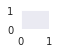

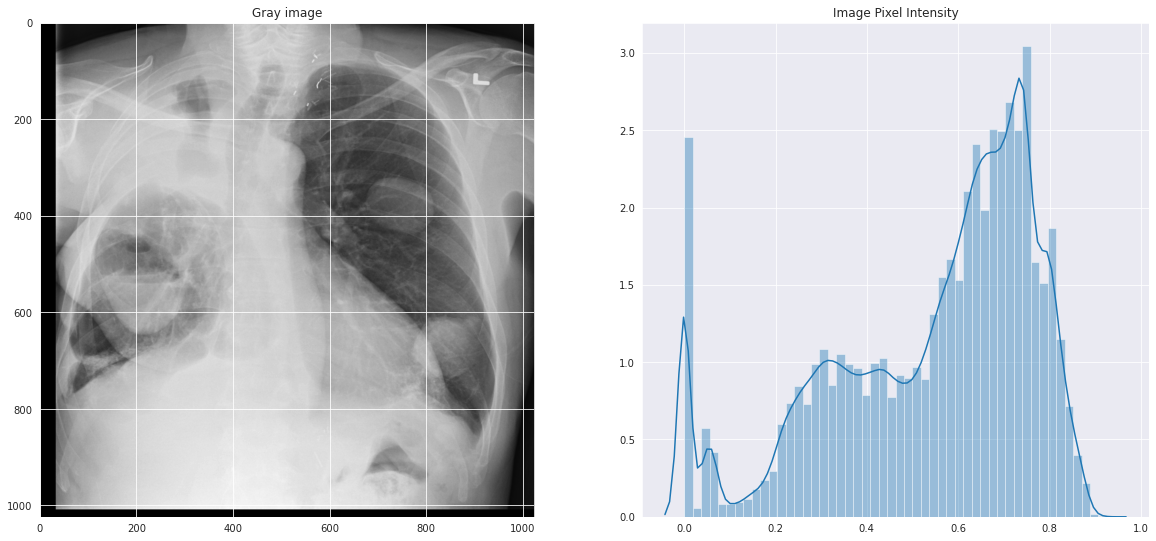

The mean of this graph is:  0.5104373
The Standard deveiation of this graph is:  0.24527152
Therefore, the Coefficient of variation would be:  0.48051253


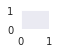

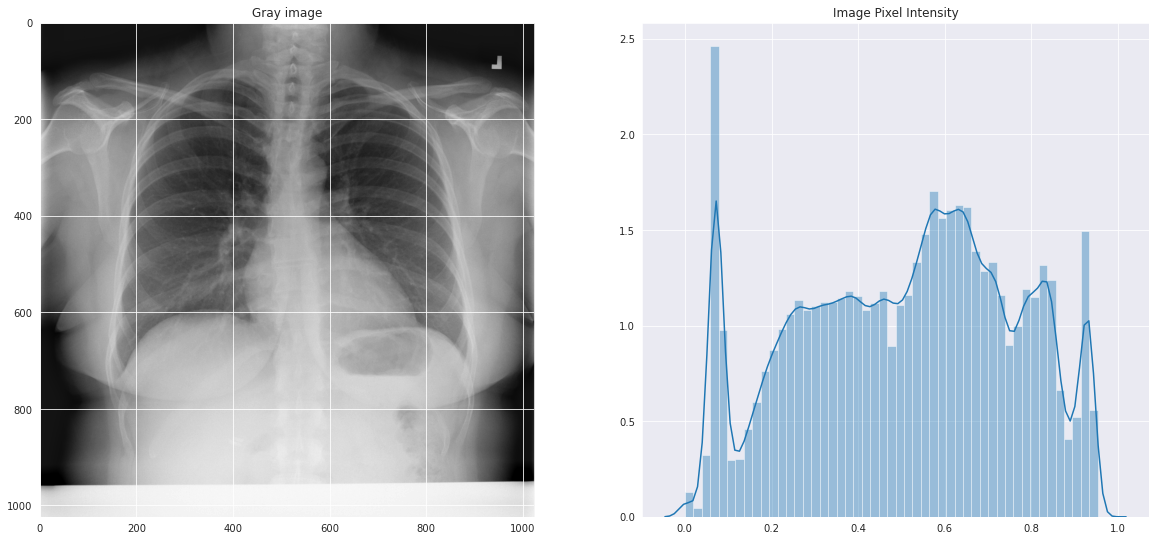

The mean of this graph is:  0.47388157
The Standard deveiation of this graph is:  0.23923425
Therefore, the Coefficient of variation would be:  0.5048398


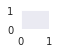

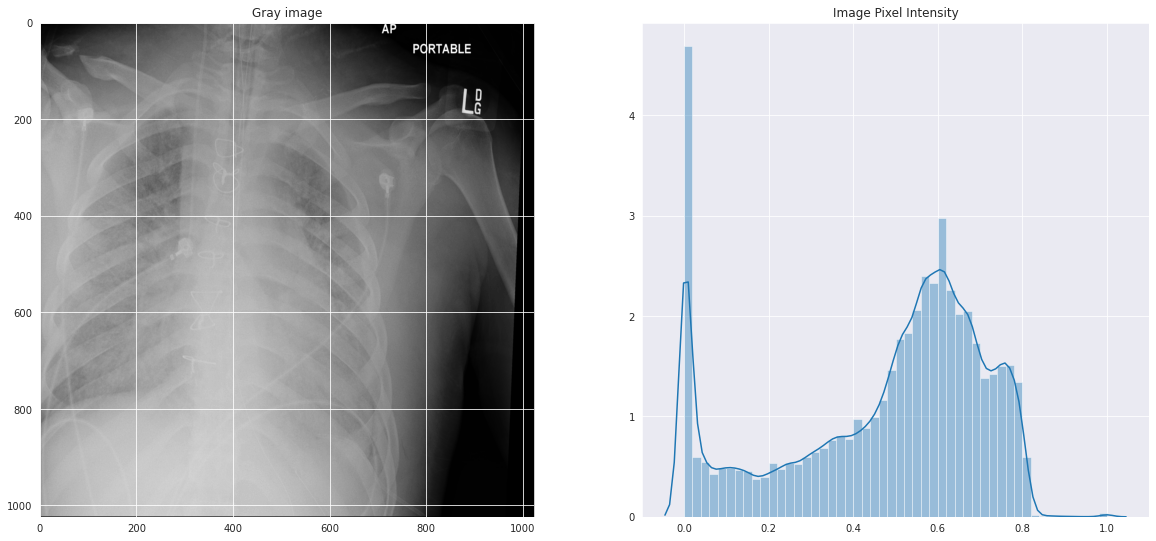

The mean of this graph is:  0.47424898
The Standard deveiation of this graph is:  0.2520487
Therefore, the Coefficient of variation would be:  0.53146917


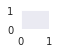

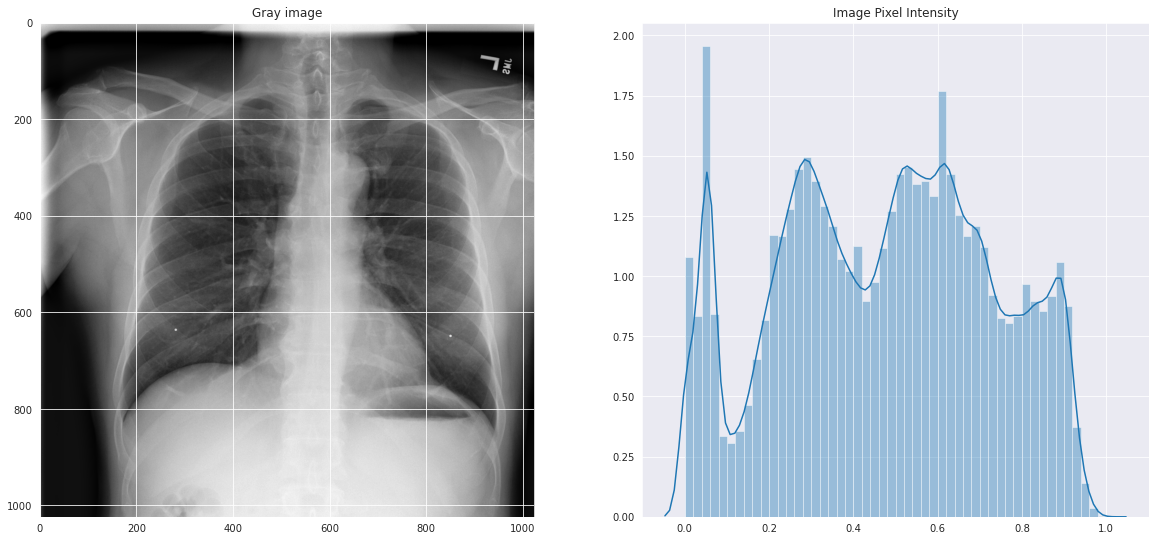

The mean of this graph is:  0.6807586
The Standard deveiation of this graph is:  0.20901525
Therefore, the Coefficient of variation would be:  0.30703285


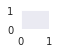

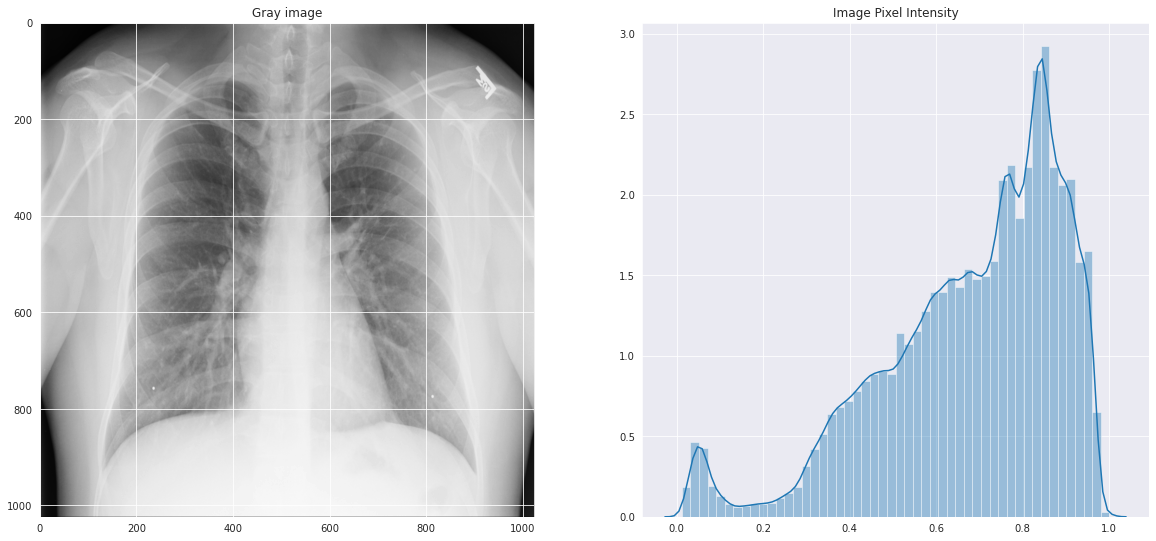

The mean of this graph is:  0.42432934
The Standard deveiation of this graph is:  0.26517192
Therefore, the Coefficient of variation would be:  0.62492007


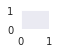

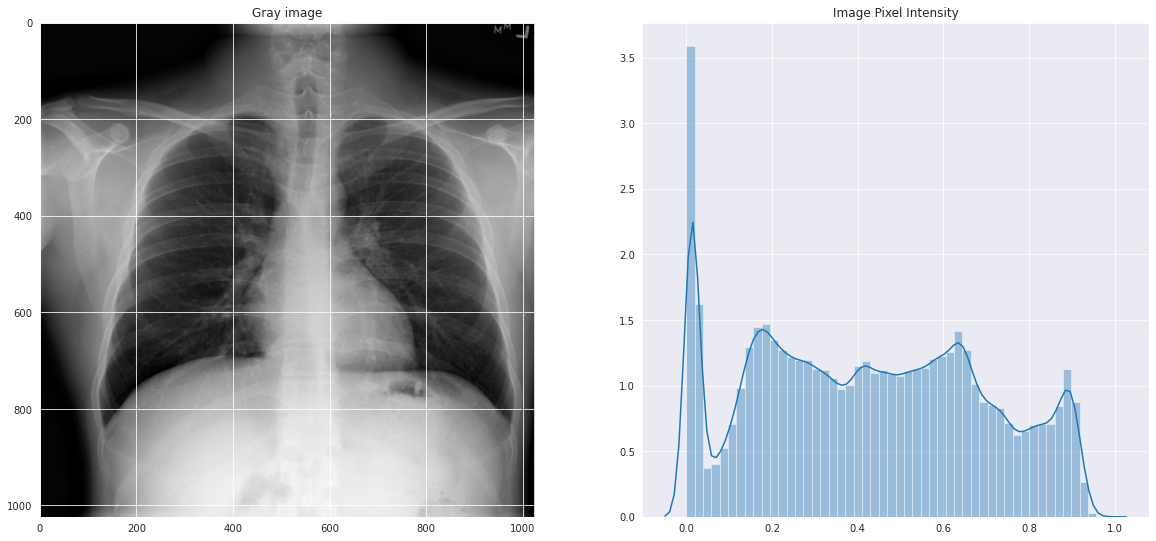

The mean of this graph is:  0.48046947
The Standard deveiation of this graph is:  0.23881762
Therefore, the Coefficient of variation would be:  0.49705055


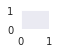

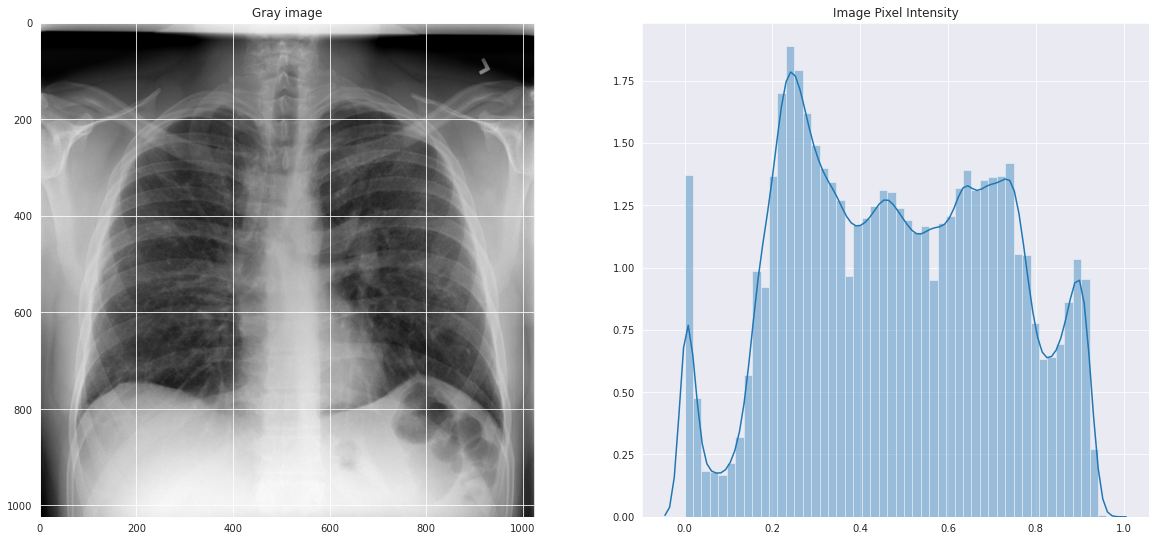

The mean of this graph is:  0.63768375
The Standard deveiation of this graph is:  0.24345751
Therefore, the Coefficient of variation would be:  0.38178408


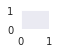

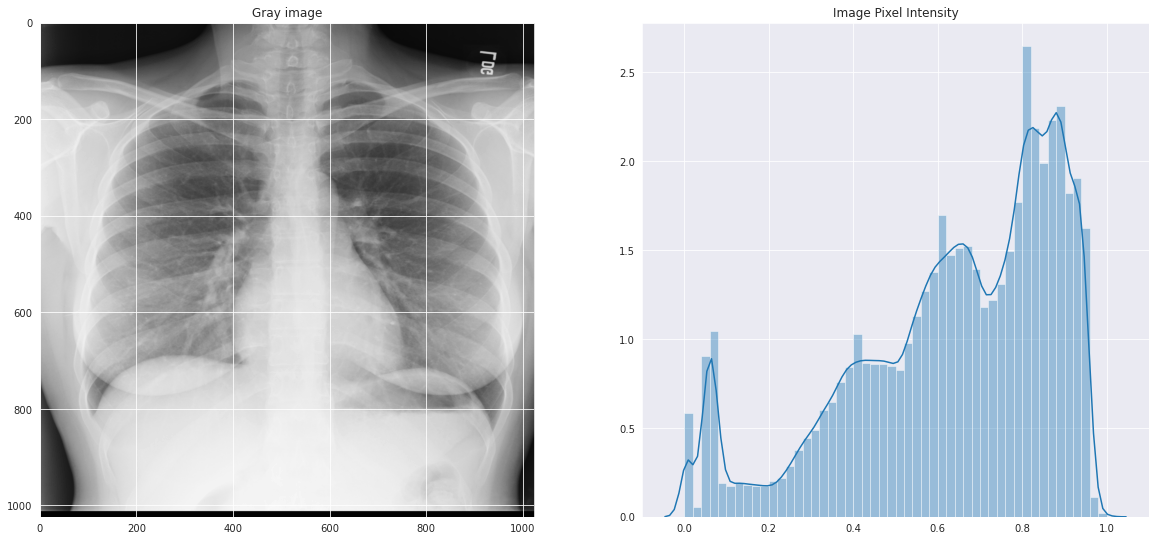

The mean of this graph is:  0.54684174
The Standard deveiation of this graph is:  0.22155364
Therefore, the Coefficient of variation would be:  0.4051513


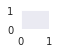

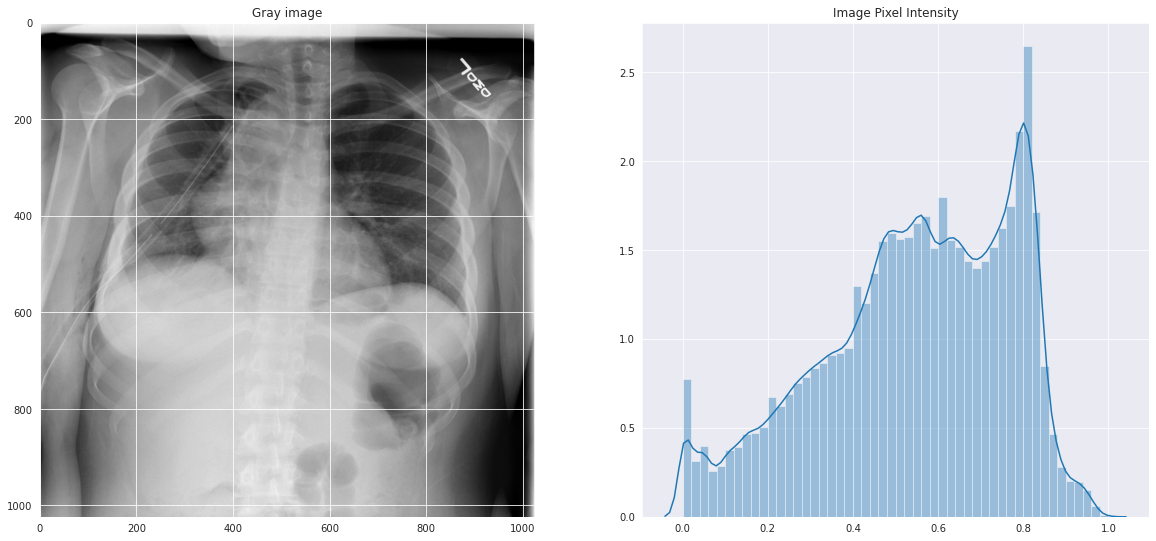

The mean of this graph is:  0.42069182
The Standard deveiation of this graph is:  0.19997454
Therefore, the Coefficient of variation would be:  0.47534686


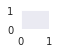

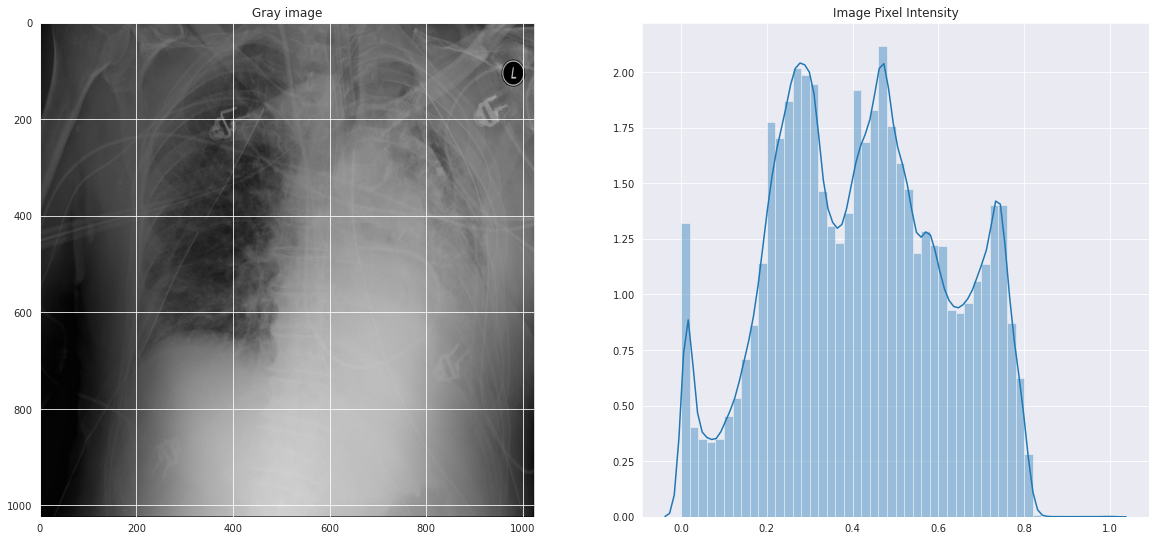

In [96]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#let's check out the sampel image
%matplotlib inline

path = "/data/images_010/images/"
file=os.listdir("/data/images_010/images")[:10] #first 20 images

import pydicom
for i,j in enumerate(file):
    file = path+j
    # images are color images
    
    plt.subplot(10,10,i+1)

    image = mpimg.imread(file) 
    
    
    
    #plt.imshow(image)
    fig = plt.figure(figsize=(20,20)) # specifying the overall grid size

    
    fig.add_subplot(221)
    plt.title('Gray image')
    plt.set_cmap('gray')
    plt.imshow(image)
    
    fig.add_subplot(222)
    plt.title('Image Pixel Intensity')
    #plt.hist(image, bins = 10)
   
    sns.set_style('darkgrid')
    sns.distplot(image)
    print("The mean of this graph is: ",image.mean())
    print("The Standard deveiation of this graph is: ",image.std())
    print("Therefore, the Coefficient of variation would be: ", image.std()/ image.mean())
 
    plt.show() 

Awesome! Now, I would say, from our 10 samples, the standard deviation of these images is not quite as low given we have a relatively low variation and from the different samples. But, if we go by the rule of thumb here, the coefficient of variation among these samples was relatively low. 
This would mean, it is   not necessary for us to separate the diseases. Also,
looking at the image and its Density, I would say much data is centered around the mean which results in a low variation. That would make a significant segmentation. Hence, our model will be feeding on a considerable amount of normalized data (diseases /properties) 
